# Covid Impact on Bike Rentals in NYC

Citi Bike, in New York City, is the largest bike share system in the U.S. Since launching in May 2013, Citi Bike has grown in size and popularity, currently offering a fleet of over 14,000 bikes, accessible at nearly 900 stations across Manhattan, Brooklyn, Queens and Jersey City. Bike share programs provide many benefits in larger cities where owning a car is not an affordable or feasible option. If you are interested in learning more about bike share programs in general, this [article](https://www.moneycrashers.com/bike-sharing-best-bike-share-programs/) on moneycrashers.com provides a decent overview along with an obligatory pros and cons list.

The date as I wrap up this project is June 9, 2020 and New York state is slowly starting the process of reopening following the man-dated shelter-in-place order issued on March 22. It remains to be seen just how long it will take for things to truly get back to normal. In the meantime, I thought it would be interesting to analyze bike rental data to see what affect, if any, the pandemic has had on NYC's bike share program. 

<img src="../img/bike-esb.png"
     alt="Citi Bike with the Empire State Building in the background"
     style="float: left; margin-right: 10px;" />


## 1. A story in 9+ million rows

From a data science perspective, there are three great things about bike share programs:

1. They usually share a good portion of their data freely with the public
2. The data is **mostly** clean and ready to go for analysis
3. They can be a great source for getting **a lot** of data for a project (\**depending on the program*)



Citi Bike is no exception to the above, providing their data in a few different formats if you want to dig in and learn more. You can visit the main [System Data page](https://www.citibikenyc.com/system-data) as a good starting point for your analysis. If you want the raw data by month though, head directly over to the [tripdata index](https://s3.amazonaws.com/tripdata/index.html).


### The data

The data files are available in csv format with the following fields:

- **tripduration** - length of rental in seconds
- **starttime** - rental start time
- **stoptime** - rental stop time
- **start station id** - id of start station 
- **start station name** - friendly name of start station
- **start station latitude** - latitude of start station
- **start station longitude** - longitude of start station
- **end station id** - id of end station
- **end station name** - friendly name of end station
- **end station latitude** - latitude of end station
- **end station longitude** - longitude of end station
- **bikeid** - id of rental bike
- **usertype** - type of user ('Subscriber' or 'Customer')
- **birth year** - birth year of renter (if known)
- **gender** - gender of renter (if known)


### The analysis

For this project, I was interested in comparing data between 2019 and 2020 to investigate the impact of Covid-19 on the overall bike share program. The monthly rollups always lag behind by about a month, so this project will focus on the period between January and April for both 2019 and 2020. All in all, this will provide over 9 million rows of data for our analysis.

<ins>The primary questions I seek to answer with this research are<ins/>:

- **Overall** - What affect has Covid-19 had overall on the total number of bike rentals or bike rental duration?
<br/>

- **Gender & Age Group** - If an affect is observed, does it vary based on gender or age group?
<br/>

- **Customer Type** - Are there any noticeable differences in behavior based on customer type?
<br/>

- **Projected Revenue Impacts** - Based on the above, what is the projected impact on program revenue?

<br/>


Let's get started!


### Import packages


In [1]:
# Import packages
import glob
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='ticks', color_codes=True, font_scale=1.25)

# Set display option for floats in Pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)


### Create some helper functions for reading and processing the data

One lesson I learned pretty quickly on this project was that 10 million rows of data can eat up memory... *fast*. My initial attempt to read in and concatenate all the files resulted in a massive datafram utilizing about **4 GB** of my system memory. Needless to say, this brought my research to a halt. Determined to press on, I did some research on memory usage in Pandas and Jupyter Notebook and found a few strategies I thought might help.

<br/>

There are some great resources out there if you want to read more about the topic. I relied on this [article](https://www.dataquest.io/blog/pandas-big-data/) from DataQuest to get me pointed down the right path.If I had to sum this up into a couple of key nuggets, they would be:

1. **Dtype matters** <br/> Optimizing your dtypes can result in up to 75% savings in memory usage in the right circumstances 
<br/>

2. **Dtype especially matters if it is object** <br/> Storing column data as an object dtype is pretty much the least efficient way to go when it comes to memory usage. Change to a more optimized dtype, or better yet, remove the data if you aren't going to use it
<br/>

3. **Only keep the data you need** <br/> See points made directly above... if you aren't using the data for your analysis, don't keep it
<br/>

4. **A pivoted datafram will speed up your plots** <br/> For my analysis, I'm looking for broad trends in the data. I don't need to plot every point. Your mileage may vary based on your project, but a pivoted dataframe with ~100 rows of data will plot faster than 10 million rows any day of the week.

<br/>

The following are a few helper functions to facilitate optimizing the files during the read-in process and to assist with pivoting the data for my plots once we get into the analysis. After optimization, I managed to get the overall memory usage down tojust over 1 GB from the original ~4 GB, which greatly improved my performance.

In [2]:
# Function for reading in and processing data files
def read_and_process(filepath, col_types, drop_cols, col_names, get_stations=False):
    '''Reads in and processes CitiBike monthly csv data files and returns a 
    dataframe containing the list of rentals for a given month
    '''
    # Read in the data
    temp_df = pd.read_csv(filepath) 
    
    # Drop rows with null values
    temp_df = temp_df.dropna()
    
    # Convert start/stop time columns to datetime
    temp_df.starttime = pd.to_datetime(temp_df.starttime, infer_datetime_format=True)
    temp_df.stoptime = pd.to_datetime(temp_df.stoptime, infer_datetime_format=True)
    
    # Convert column dtypes
    temp_df = temp_df.astype(col_types)
    
    if get_stations == True:  # Process station data
        temp_stations = process_station_data(temp_df)  
    
    # Drop unnecessary or redundant columns
    temp_df = temp_df.drop(drop_cols, axis=1)
    
    # Rename remaining columns
    temp_df.columns = col_names
    
    # Return df object(s) based on params
    if get_stations == True: 
        return temp_df, temp_stations
    else:
        return temp_df


# Function for abstracting out station-related data for location-based analysis
def process_station_data(df):
    '''Processes and abstracts station-related data and returns as a separate dataframe
    '''
    # New column names
    cols = ['id', 'name', 'lat', 'lon']

    # Temp df for start stations
    start_stations = df[['start station id', 'start station name',
                         'start station latitude', 'start station longitude']]
    start_stations.columns = cols
    start_stations = start_stations.drop_duplicates()

    # Temp df for end stations
    end_stations = df[['end station id', 'end station name',
                       'end station latitude', 'end station longitude']]
    end_stations.columns = cols
    end_stations = end_stations.drop_duplicates()
    
    # Concatenate the start/end station dfs and drop dups 
    temp_stations = pd.concat([start_stations, end_stations],
                              ignore_index=True).drop_duplicates()
    
    return temp_stations


# Function for pivoting dataframe for plotting
def pivot_df(df, pv_index, pv_columns, pv_values, scale, reset=False, cumsum=False, impute=False):
    """Returns a pivoted version of a dataframe to aid in plotting
    """
    # Create pivot table
    df_pivot = df.pivot_table(index=pv_index, columns=pv_columns, values=pv_values, aggfunc=np.sum)

    # Impute values for 2019-02-29 to account for leap year in 2020 
    if impute == True:
        df_pivot = df_pivot.fillna(df_pivot[2019].mean())

    # Convert to running total
    if cumsum == True:
        df_pivot = df_pivot.cumsum()
    
    # Scale values 
    df_pivot = df_pivot.apply(lambda x: round((x * scale),2), axis=1)

    # Reset the index
    if reset == True:
        df_pivot = df_pivot.reset_index()
    
    return df_pivot


### Prep for import and read in the data

Now that we have a couple of helper functions to get us started, we're ready to read in the data files. First we will create a few variables required for input into the **read_and_process** function and then it's off to the races. (Actually, this part take a couple of minutes to complete, so see you on the other side.)


In [3]:
# Dictionary of columns and optimal dtypes
col_types = {'usertype': 'category', 'birth year': 'int', 'gender': 'int8'}

# Create list of updated column names
col_names = ['tripduration', 'starttime', 'usertype', 'birth_year', 'gender']

# Create list of columns to drop
drop_cols = ['stoptime', 'start station id', 'end station id', 'start station name',
             'start station latitude', 'start station longitude', 'end station name',
             'end station latitude', 'end station longitude', 'bikeid']

# Read in and process the data
data_files = glob.glob('../data/' + "*.csv")
rentals_dfs = []
for file in data_files:
    rentals_df = read_and_process(file, col_types, drop_cols, col_names)
    rentals_dfs.append(rentals_df)

# Concatentate the list of temp dfs
df = pd.concat(rentals_dfs, ignore_index=True)

# Check out the data!
rows = df.shape[0]
print(str(rows) + " Rows")

9143693 Rows



## 2. So how does a global pandemic affect bike rentals anyway?

Now that we have the data files read into a dataframe, we can dig into the analysis. The first question on the list is... What affect has Covid-19 had overall on the total number of bike rentals or bike rental duration?

To facilitate this analysis and to help in our plotting throughout, we'll add a few additional columns for rental count and for date related info (hour, day, month, year). And then we'll drop the starttime column to reclaim some memory. 

I know, I know... earlier I told you only to keep the data you need. So why am I adding these columns now? The simple answer is that these columns will make pivoting our data by month and year *much* easier throughout the notebook. And, since they all go in as int columns, the additional size will be somewhat negligible. 

(Note - I could do more to optimize the specific type of *int* column - int8, int16, int32, etc. - but in playing around with this a bit, I didn't see much improvement in overall performance. I'll save that optimization as a TODO for later.)

After we get our new columns, we'll pivot rental counts and durations by month and year to see the results.

### Create new columns for rental count and day/month/year

In [4]:
# Sort the dfs by starttime
df = df.sort_values(by=['starttime']).reset_index(drop=True)

# Create a column to facilitate totaling rental count
df['rental_count'] = 1

# Create new columns for day, month and year
df['hour'] = df.starttime.dt.hour
df['day'] = df.starttime.dt.day
df['month'] = df.starttime.dt.month
df["year"] = df.starttime.dt.year

# Drop starttime column
df = df.drop('starttime', axis=1)


### Total rentals by month, 2019 vs. 2020


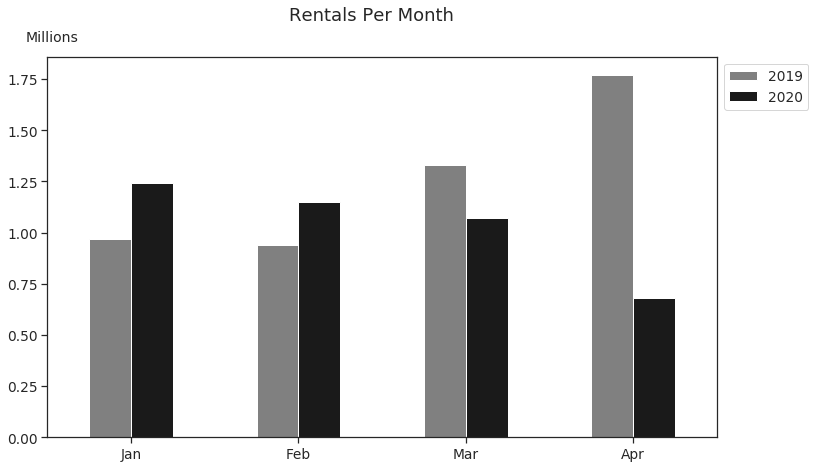

In [5]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month'], ['year'], 'rental_count', 0.000001)

# Rename index to friendly month names
df_pivot.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr'}, inplace=True)

# Plot the data and set style
labels = ['Jan', 'Feb', 'Mar', 'Apr']
df_pivot.plot(kind='bar', figsize=(12, 7), rot=0, label=labels, color=['gray', 'k'])
plt.text(0.1, .91, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.xlabel(None)
plt.suptitle("Rentals Per Month", fontsize=18)
# plt.title("(CitiBike NYC)", fontsize=14, pad=16)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));

#### A downward trend in 2020

Based on total rental counts by month, we do see a steady trend downward in 2020, versus a *mostly* steady trend upward in 2019. In particular, it looks like rental counts dropped off significantly between March and April. This is especially apparent when looking at the comparison between April 2019 and April 2020.

This result is not too surprising given the situation, with the pandemic leaving many unemployed and many others forced to WFH. Before we draw any conclusions, let's take a closer look.


### Running total of rentals by day, year-over-year

Next, let's drill into total cumulative rental counts by day to see if we can detect the point that rental numbers started dropping off. For this plot, I've added vertical lines corresponding with a couple of key dates related to Covid-19.

- **March 11** - Covid-19 Declared a Global Pandemic
- **March 22** - New York state under order to *shelter-in-place*



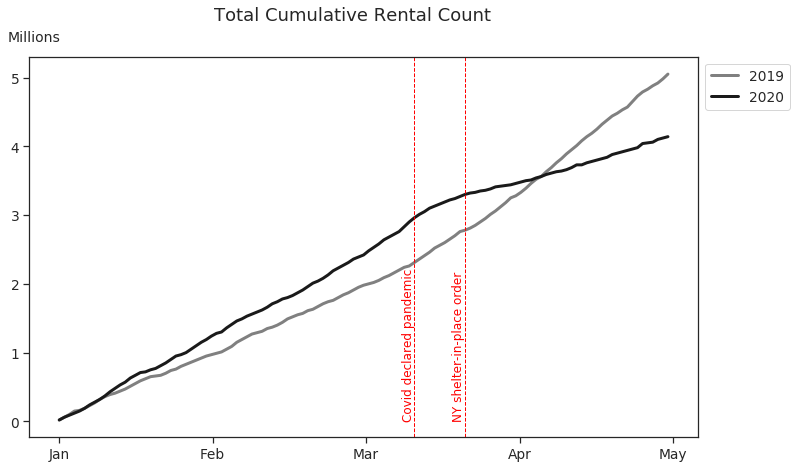

In [7]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'day'], ['year'], 'rental_count', 1.00E-6, cumsum=True, impute=True)

# Plot a line chart and set the chart style
df_pivot.plot(kind='line', linewidth=3, figsize=(12, 7), color=['gray', 'k'])

# Plot vertical lines for key dates
plt.axvline(x=70, color='red', linestyle='--', linewidth=1)
plt.text(67.5,0.05,'Covid declared pandemic',rotation=90, fontsize=12, color='red')
plt.axvline(x=80, color='red', linestyle='--', linewidth=1)
plt.text(77.5,0.05,'NY shelter-in-place order',rotation=90, fontsize=12, color='red')

# Add labels and legend
plt.text(0.1, .91, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.suptitle("Total Cumulative Rental Count", fontsize=18)
# plt.title("(millions of rentals)", fontsize=14, pad=16)
plt.xticks(np.linspace(0, 121, num=5), ['Jan', 'Feb', 'Mar', 'Apr', 'May'])
plt.xlabel(None)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));


#### Shelter-in-place = fewer bike rentals

This view provides a nice picture regarding the timing of the downward trend starting in mid-March and continuing through April. A slight decline is apparent shortly after the pandemic declaration, with a more noticeable shift after the stay-at-home decree.


In [ ]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month'], ['year'], 'rental_count', 0.000001)

# Rename index to friendly month names
df_pivot.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr'}, inplace=True)

# Plot the data and set style
labels = ['Jan', 'Feb', 'Mar', 'Apr']
df_pivot.plot(kind='bar', figsize=(12, 7), rot=0, label=labels, color=['gray', 'k'])
plt.text(0.1, .91, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.xlabel(None)
plt.suptitle("Rentals Per Month", fontsize=18)
# plt.title("(CitiBike NYC)", fontsize=14, pad=16)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));


## 3. What's the affect on rental durations?

So based on what we've seen so far, it's safe to say people are renting fewer bikes during a pandemic, but how does this translate in terms of rental durations? 

Let's take a look at the same view as above, but this time we'll pivot on the tripduration dimension to see if the result matches what we see for rental counts.


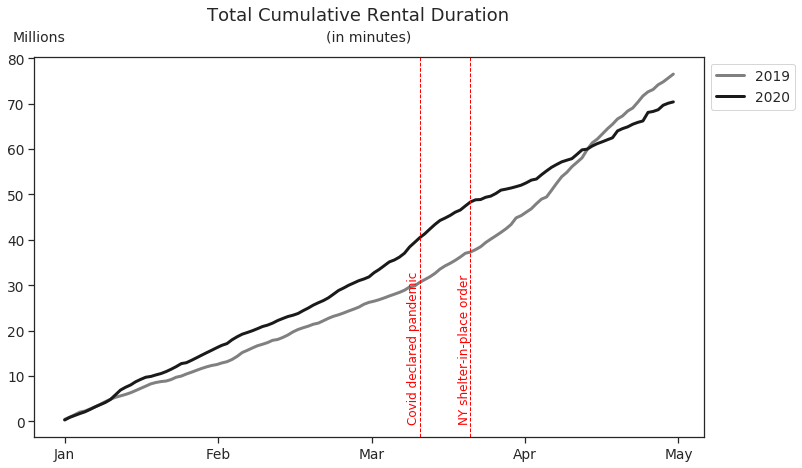

In [8]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'day'], ['year'], 'tripduration', 1.667E-8, cumsum=True, impute=True)

# Plot a line chart and set the chart style
df_pivot.plot(kind='line', linewidth=3, figsize=(12, 7), color=['gray', 'k'])

# Plot vertical lines for key dates
plt.axvline(x=70, color='red', linestyle='--', linewidth=1)
plt.text(67.5,0.05,'Covid declared pandemic',rotation=90, fontsize=12, color='red')
plt.axvline(x=80, color='red', linestyle='--', linewidth=1)
plt.text(77.5,0.05,'NY shelter-in-place order',rotation=90, fontsize=12, color='red')

# Add labels and legend
plt.text(0.1, .91, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
plt.suptitle("Total Cumulative Rental Duration", fontsize=18)
plt.title("(in minutes)", fontsize=14, pad=16)
plt.xticks(np.linspace(0, 121, num=5), ['Jan', 'Feb', 'Mar', 'Apr', 'May'])
plt.xlabel(None)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));


#### Duration stays strong despite the pandemic

Looking at the corresponding view for cumulative rental duration, it appears almost unaffected by the pandemic announcement, only starting to taper down following the shelter-in-place order. Further, the total cumulative duration at the end of April appears to be less impacted than the view of total cumulative rental counts. 

So what does this mean? Are people riding bikes for for longer durations on average during the pandemic than they were prior? Let's dig in and find out. For this analysis, we'll take a look at average rental durations by month for 2019 vs. 2020.



### Average rental duration by month, 2019 vs. 2020


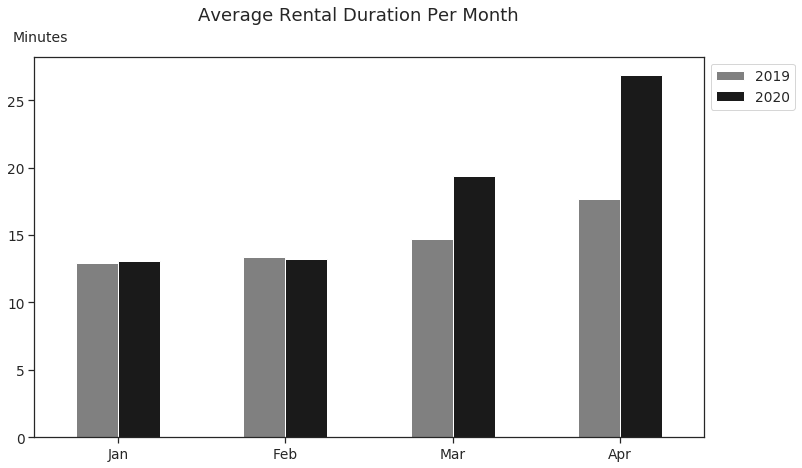

In [13]:
# Create pivot table
df_pivot = df.pivot_table(index='month', columns='year', values='tripduration', aggfunc=np.mean)

# Scale values 
df_pivot = df_pivot.apply(lambda x: round((x / 60),2), axis=1)

# Rename index to friendly month names
df_pivot.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr'}, inplace=True)

# Plot the data and set style
labels = ['Jan', 'Feb', 'Mar', 'Apr']
df_pivot.plot(kind='bar', figsize=(12, 7), rot=0, label=labels, color=['gray', 'k'])
plt.text(0.1, .91, 'Minutes', fontsize=14, transform=plt.gcf().transFigure)
plt.xlabel(None)
plt.suptitle("Average Rental Duration Per Month", fontsize=18)
# plt.title("(in minutes)", fontsize=14, pad=16)
plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));


#### Where are people going?

Our earlier suspicion is confirmed when looking at average rental duration per month. That is to say, while rental counts are on the decline, average rental durations are increasing. This begs the question, *where are people going?*

Some possible theories...
1. People have more time on their hands and biking feels like a safe way to get outside and avoid people (assuming the bikes are cleaned well... yikes!)
<br/>

2. With so many businesses shut down and/or with so many items out of stock, people had to travel further than normal to buy food, or more likely, to find toilet paper or hand sanitizer.
<br/>

3. Similar to 1 above but with a twist... with gyms temporarily shut down, rental bikes provided would-be spinners a means of getting their *Soul Cycle* fix  

Later on, we can utilize the station info to investigate this question further. For now, let's move on to the next question on our original list... 



## 4. Do age or gender make a difference?

Next on our list is to take a look at our data along the dimensions of age and gender. Starting with gender, we have three categories in our data - male, female and not specified. For age, we can use the birth year field to categorize our riders into three age groups - under 35, 35-55 and over 55.

In keeping with our above analysis, let's see if we can find any patterns in the data that would indicate behavioral changes for these groups related to total rentals or total rental duration.

Before we get started plotting our data, we need a new helper function that will enable us to create subplots for each of our different categories.



### Create helper function for creating subplots by category


In [14]:
# Create helper function for creating subplots
def make_plot(df, x_labels, num_plots, facet, y_min, y_max, subtitle, title, x_pos_suptitle, x_pos_title):
    """Returns a plot with a series of subplots based on a pivoted df and the chosen facet
    """
    # Set x labels
    x_labels = x_labels

    # Create figure and pad the subplots
    fig = plt.figure(figsize=(16,4))
    # fig.subplots_adjust(wspace=0.3) # Use to adjust spacing on plots if needed

    # Create a subplot for each facet
    for i in range(num_plots):
        df_temp = df_pivot[df_pivot[facet] == i]
        df_temp_pivot = df_temp.pivot_table(index=['month'], values=[2019,2020], aggfunc=np.sum)

        # Extract x and y values 
        x = df_temp_pivot.index.to_list()
        y1 = df_temp_pivot.iloc[:,0].to_list()
        y2 = df_temp_pivot.iloc[:,1].to_list()
        
        # Create elements to zip y values
        y = [y1, y2]
        labels = ['2019', '2020']
        colors = ['gray', 'k']

        # Plot the values
        plt.subplot(1,3, (i+1))
        for y_arr, label, color in zip(y, labels, colors):
            plt.plot(x, y_arr, color=color, label=label, linewidth=2, marker='o')
        plt.xticks(np.linspace(1, 4, 4), ['Jan', 'Feb', 'Mar', 'Apr'])
        plt.xlabel(x_labels[i], labelpad=16)
#         if i !=0:                                  # An option to remove yticklabels on inner plots
#             plt.yticks(np.linspace(-0, 5, 5), " ") # Will require abstraction of spacing if implemented
        plt.ylim(y_min, y_max) 
        
    # Add legend and show the plot
    plt.text(0.1, .94, 'Millions', fontsize=14, transform=plt.gcf().transFigure)
    plt.suptitle(subtitle, y=1.05, x=x_pos_suptitle, fontsize=18)
    plt.title(title, fontsize=14, pad=16, y=1.0, x=x_pos_title)
    plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1));
    plt.show()     


### Plot cumulative rental count and duration by gender


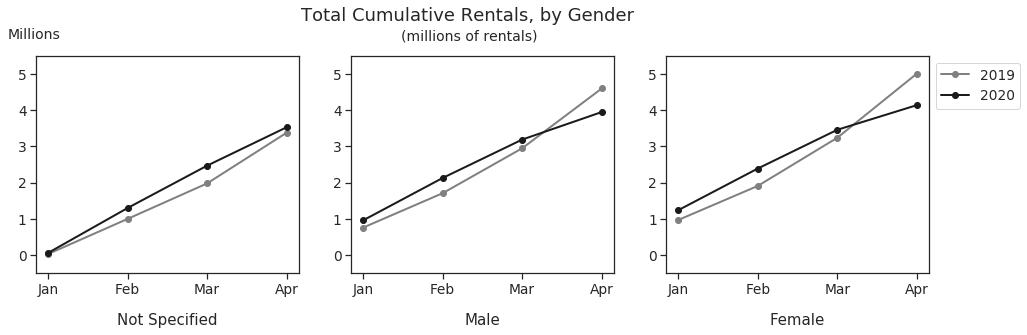

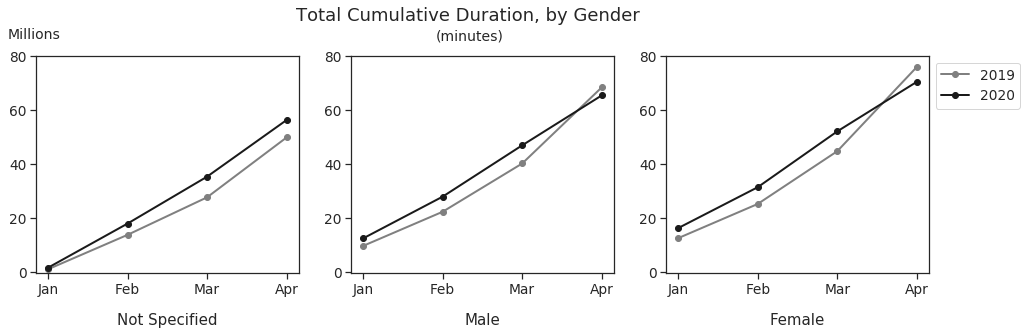

In [17]:
# RENTAL COUNT

# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'gender'], ['year'], 'rental_count', 1.00E-6,
                    cumsum=True, impute=True, reset=True)

# Configure variables
x_labels = ['Not Specified', 'Male', 'Female']
num_plots = 3
facet = 'gender'
y_min, y_max = -0.5, 5.5
subtitle = "Total Cumulative Rentals, by Gender"
title = "(millions of rentals)"
x_pos_suptitle, x_pos_title = 0.5, -0.75

# Call the helper function to make the plot
make_plot(df, x_labels, num_plots, facet, y_min, y_max, subtitle, title, x_pos_suptitle, x_pos_title)


# RENTAL DURATION 

# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'gender'], ['year'], 'tripduration', 1.667E-8,
                    cumsum=True, impute=True, reset=True)

# Update variables
y_min, y_max = -0.5, 80
subtitle = "Total Cumulative Duration, by Gender"
title = "(minutes)"

# Call the helper function to make the plot
make_plot(df, x_labels, num_plots, facet, y_min, y_max, subtitle, title, x_pos_suptitle, x_pos_title)


#### Working title

Insert analysis


### Create and assign age groups


In [18]:
# Create function to return decade for a given year
def assign_age_cat(year):
    """Returns 1 digit age category when passed 4 digit year    
    """
    if (year > 1985) and (year <= 2005):
        age_cat = 0
    elif (year >= 1970) and (year <= 1985):
        age_cat = 1
    elif (year >= 1920) and (year < 1970):
        age_cat = 2
    else:
        age_cat = 3
    return age_cat

In [19]:
# Create new column for decade and populate with function
df["age_cat"] = df['birth_year'].apply(assign_age_cat)

# Drop rows with no birth year
df = df[df.age_cat != 3]


### Plot cumulative rental count and duration by age group


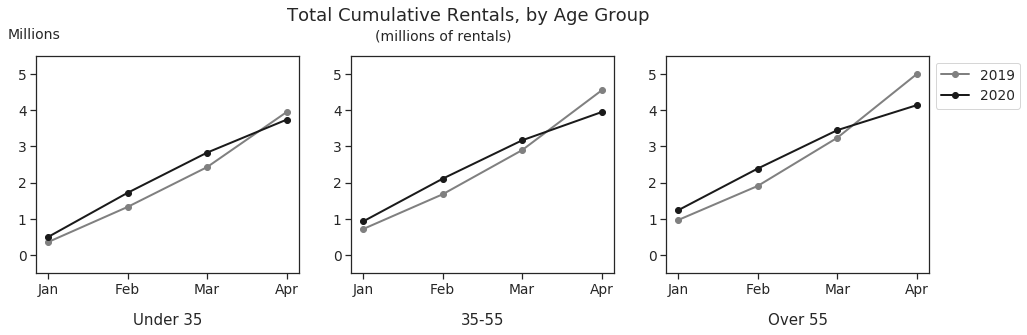

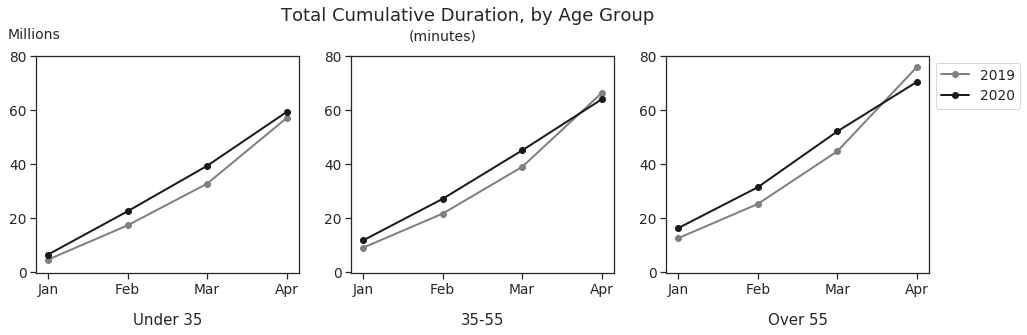

In [20]:
# RENTAL COUNT

# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'age_cat'], ['year'], 'rental_count', 1.00E-6,
                    cumsum=True, impute=True, reset=True)

# Update variables
x_labels = ['Under 35', '35-55', 'Over 55']
facet = 'age_cat'
y_min, y_max = -0.5, 5.5
subtitle = "Total Cumulative Rentals, by Age Group"
title = "(millions of rentals)"
x_pos_suptitle, x_pos_title = 0.5, -0.85

# Call the helper function to make the plot
make_plot(df, x_labels, num_plots, facet, y_min, y_max, subtitle, title, x_pos_suptitle, x_pos_title)


# RENTAL DURATION 

# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'age_cat'], ['year'], 'tripduration', 1.667E-8,
                    cumsum=True, impute=True, reset=True)

# Update variables
y_min, y_max = -0.5, 80
subtitle = "Total Cumulative Duration, by Age Group"
title = "(minutes)"

# Call the helper function to make the plot
make_plot(df, x_labels, num_plots, facet, y_min, y_max, subtitle, title, x_pos_suptitle, x_pos_title)


#### Working title

TBD analysis


## 4. How is this impacting the bottom line?

TBD intro


### Plot cumulative rental count and duration by user type


In [ ]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'usertype'], ['year'], 'rental_count', 1.00E-6,
                    cumsum=True, impute=True, reset=True)

# Replace usertype values with 0 and 1
dict = {'Customer': 0, 'Subscriber': 1}
df_pivot = df_pivot.replace({"usertype": dict}) 

# Update variables
x_labels = ['Casual Customer', 'Subscriber']
num_plots = 2
facet = 'usertype'
y_min, y_max = -0.5, 5.5
subtitle = "Total Cumulative Rentals, by User Type"
title = "(millions of rentals)"
x_pos_suptitle, x_pos_title = 0.35, -0.25

# Call the helper function to make the plot
make_plot(df, x_labels, num_plots, facet, y_min, y_max, subtitle, title, x_pos_suptitle, x_pos_title)

In [ ]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['month', 'usertype'], ['year'], 'tripduration', 1.667E-8,
                    cumsum=True, impute=True, reset=True)

# Replace usertype values with 0 and 1
dict = {'Customer': 0, 'Subscriber': 1}
df_pivot = df_pivot.replace({"usertype": dict}) 

# Update variables
y_min, y_max = -5, 80
subtitle = "Total Cumulative Duration, by User Type"
title = "(minutes)"

# Call the helper function to make the plot
make_plot(df, x_labels, num_plots, facet, y_min, y_max, subtitle, title, x_pos_suptitle, x_pos_title)



TBD summary




## 5. What is the impact in terms of peak bike usage, by hour of day and area?


### Plot distribution of rentals and duration by hour of day


In [ ]:
# Helper function for plotting

def plot_hr_dist(df, y_tick_loc, y_min, y_max, y_axis_label, suptitle, title):
    """Returns a plot based on a pivoted df
    """
    # Set x labels and x values
    x_labels = ['Jan', 'Feb', 'Mar', 'Apr']
    x = df_pivot.index.to_list()

    # Set colors & labels
    colors = {2019:'gray', 2020: 'k'}
    labels = {2019:'2019', 2020: '2020'}

    # Create figure and pad the subplots
    fig = plt.figure(figsize=(16,7))
    fig.subplots_adjust(wspace=0.3)

    # Create a subplot for each month, year combination
    for year in range(2019, 2021, 1):
        for i in range(4):
            # Extract y values 
            y = df_pivot[year, i+1]

            # Plot the values
            if year == 2020:
                i=i+4
            plt.subplot(2, 4, (i+1))
            plt.bar(x, y, label=labels[year], color=colors[year])
            
            # Set xticks including tick labels for bottom row
            if i > 3:
                plt.xticks(np.linspace(0, 24, 5), ['12am', '6am', '12pm', '6PM'], rotation=0, fontsize=12)
                plt.xlabel(x_labels[i-4], labelpad=16)
            else:
                plt.xticks(np.linspace(0, 24, 5), " ")

            # Set yticks including tick labels for bottom row
            if i !=0 and i !=4:
                plt.yticks(y_tick_loc, " ")
            
            # Set axis limits
            plt.ylim(y_min, y_max)
            plt.xlim(-.5,23.5)

            # Configure legend for outermost column
            if i == 3 or i == 7:
                plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 1))
    #         elif i == 7: # Use if desired to group legends 
    #             plt.legend(title=None, loc='upper left', bbox_to_anchor=(1, 2))

    # Add text & titles
    plt.text(0.1, .92, y_axis_label, fontsize=14, transform=plt.gcf().transFigure)
    plt.suptitle(suptitle, y=1, x=.5, fontsize=18)
    plt.title(title, fontsize=14, pad=16, y=2.25, x=-1.6)

    # Show the plot
    plt.show()

In [ ]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['hour'], ['year', 'month'], 'rental_count', 1.00E-3,
                    impute=True, reset=True)

# Configure variables
y_tick_loc = np.linspace(0, 200, 5)
y_min, y_max = 0, 180
y_axis_label= 'Thousands'
suptitle = "Rental Distribution by Hour of Day, Jan-Apr"
title = "(thousands of rentals)"

# Call the helper function to make the plot
plot_hr_dist(df, y_tick_loc, y_min, y_max, y_axis_label, suptitle, title)

In [ ]:
# Pivot df using helper function
df_pivot = pivot_df(df, ['hour'], ['year', 'month'], 'tripduration', 1.667E-8,
                    impute=True, reset=True)

# Update variables
y_tick_loc = np.linspace(0, 3, 6)
y_min, y_max = 0, 3
y_axis_label= 'Millions'
suptitle = "Rental Duration Distribution by Hour of Day, Jan-Apr"
title = "(minutes)"

# Call the helper function to make the plot
plot_hr_dist(df, y_tick_loc, y_min, y_max, y_axis_label, suptitle, title)

TBD - Summary


### Clear memory for new analysis


In [ ]:
del df_temp_pivot
del df_pivot
del df


### Prep for import and read in the data


In [ ]:
# Dictionary of columns and optimal dtypes
col_types = {'start station id': 'int', 'end station id': 'int'}

# Create list of updated column names
col_names = ['starttime', 'stoptime', 'start_station_id', 'end_station id']

# Create list of columns to drop
drop_cols = ['gender', 'tripduration', 'birth year', 'start station name',
             'start station latitude', 'start station longitude', 'end station name',
             'end station latitude', 'end station longitude', 'bikeid', 'usertype']

# Create lists for each set of dataframes
rentals_dfs = []
station_dfs = []

# Read in and process the data
data_files = glob.glob('../data/' + "*.csv")
for file in data_files:
    rentals_df, station_df = read_and_process(file, col_types, drop_cols, col_names, get_stations=True)
    rentals_dfs.append(rentals_df)
    station_dfs.append(station_df)

# Concatenate into 2 dataframes - rentals & stations and drop duplicate stations
df = pd.concat(rentals_dfs, ignore_index=True)
stations = pd.concat(station_dfs, ignore_index=True).drop_duplicates(subset='id', keep="first")

# Calculate memory usage
rentals_mem = df.memory_usage().sum() / 1024**2
stations_mem = stations.memory_usage().sum() / 1024**2

# Print output
print("Rentals: " + str(df.shape[0]) + " rows")
print('Memory usage after optimization:  {:.2f} MB'.format(rentals_mem))
print("Stations: " + str(stations.shape[0]) + " rows")
print('Memory usage after optimization:  {:.2f} MB'.format(stations_mem))

In [ ]:
df.head()

In [ ]:
stations.head()


## 5. Which areas are most impacted?


In [ ]:
import fiona
import geopandas as gpd

from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.plotting import figure, show, save
from bokeh.io import show, output_file, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper,GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import Reds6 as palette
from bokeh.resources import CDN
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon
from shapely.prepared import prep
from mpl_toolkits.basemap import Basemap   
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from descartes import PolygonPatch

# Setup Bokeh to output directly to the notebook
output_notebook(resources=None, verbose=False, hide_banner=True, load_timeout=5000, notebook_type='jupyter')

In [ ]:
#Turn the GeoJson file into a data frame and merge it with df 
data = '../data/nyc_zips.geojson'
gdf = gpd.read_file(data)
# merge = gdf.merge(df, how='left', on='postalCode')
gdf